In [2]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3Si_S18_2um.tiff',
    placeholder='Type something',
    description='File path:',
    disabled=False
)

display(path)

file_name = widgets.Text(
    placeholder='Type something',
    description='File path:'
)

fac_1 = widgets.FloatText(
    description='fac 1'
)

fac_2 = widgets.FloatText(
    description='fac 2'
)

fac_3 = widgets.FloatText(
    description='fac 3'
)

fac_4 = widgets.FloatText(
    description='fac 4'
)

display(file_name)

ui = widgets.HBox([fac_1, fac_2,fac_3,fac_4])

display(ui)



Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3Si_S18_2um.tiff', description='Fi…

Text(value='', description='File path:', placeholder='Type something')

In [75]:
%matplotlib inline
import ipyvolume as ipv
import matplotlib.pyplot as plt
from skimage import data, io, filters
import numpy as np

from skimage import data, io, filters
## C:\Users\inst\SynologyDrive\Master\Exp\Hi-am\data\2019-04-10 - Issa - Fe3Si -S08 (unlabelled, green)_2um scan_recon.tiff
stack = io.imread(path.value).T


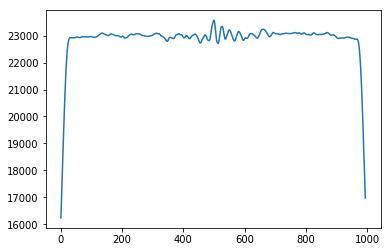

In [76]:
mean_z_intensity = np.mean(stack, axis = (0,1))

fig, ax = plt.subplots()
ax.plot(range(mean_z_intensity.shape[0]), mean_z_intensity)
plt.show()

In [77]:
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

cpt = importr('changepoint')

cpm_result = cpt.multiple_mean_norm(FloatVector(mean_z_intensity),"BinSeg","MBIC",0,2,True,True,1)

change_pts = cpt.cpts(cpm_result)

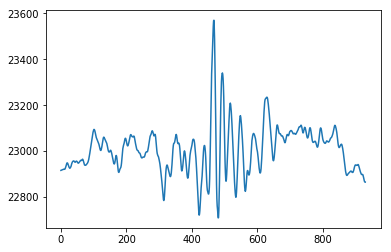

In [78]:
bot = int(change_pts[0])+20
top = int(change_pts[1])-20
cut_warp = mean_z_intensity[bot:top]

fig, ax = plt.subplots()
ax.plot(range(cut_warp.shape[0]), cut_warp)
plt.show()

Text(0.5,1,'crop')

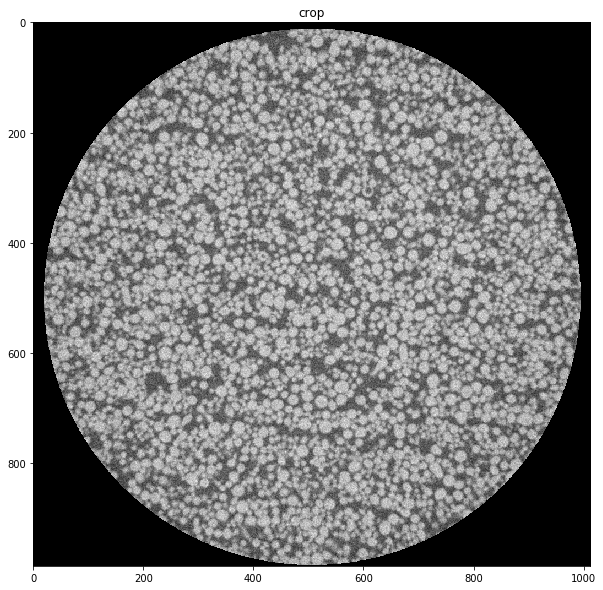

In [79]:
cropped = stack[:,:,bot:top]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cropped[:,:,100], cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('crop')

In [80]:

slice_num = widgets.IntSlider(
    value=7,
    min=0,
    max=cropped.shape[0],
    step=1
)

display(slice_num)

IntSlider(value=7, max=988)

In [81]:
single_s = cropped[:,:,slice_num.value]

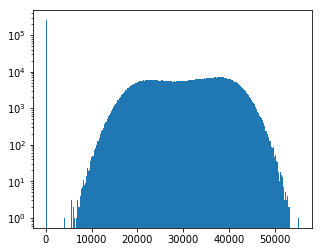

In [82]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.ravel(single_s), bins=256)
ax.set_yscale("log", nonposy='clip')


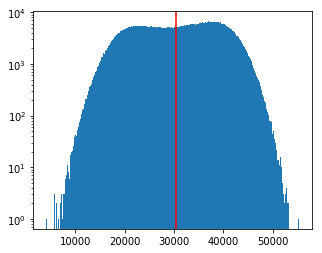

In [83]:
from skimage.filters import threshold_otsu
import numpy.ma as ma

masked = ma.masked_where(single_s == 0, single_s)

thresh = threshold_otsu(masked.compressed())

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.ravel(masked.compressed()), bins=256)
ax.axvline(thresh, color='r')
ax.set_yscale("log", nonposy='clip')


Text(0.5,1,'segmented')

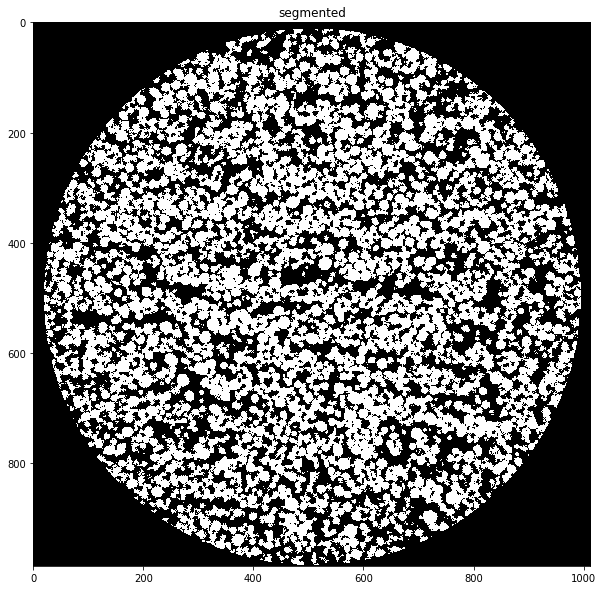

In [84]:
binary = single_s < thresh

new_im = np.copy(single_s)

new_im[binary] = 0
new_im[~binary] = 1

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_im, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmented')

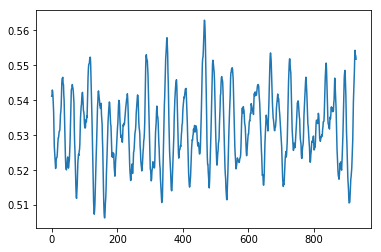

In [85]:
def density(im):
    height = im.shape[2]
    z_mean = np.zeros(height)
    for z in range(height): 
        sl = im[:,:,z]
        masked = ma.masked_where(sl == 0, sl)
        thresh = threshold_otsu(masked.compressed())

        binary = sl < thresh

        new_im = np.copy(sl)

        new_im[binary] = 0
        new_im[~binary] = 1

        n_masked = ma.masked_where(sl==0,new_im)
        z_mean[z] = np.mean(n_masked)
    return z_mean


z_mean = density(cropped)
fig, ax = plt.subplots()
ax.plot(range(cropped.shape[2]), z_mean)
plt.show()

In [86]:
import pandas as pd

df = pd.DataFrame(columns = ['fac_1','fac_2','fac_3','fac_4','z','density'])

for z in range(z_mean.shape[0]):
    df.loc[z] = [fac_1.value,fac_2.value,fac_3.value,fac_4.value,z,z_mean[z]]
print(df)

     fac_1  fac_2  fac_3  fac_4      z   density
0      0.0    0.0    0.0    0.0    0.0  0.541140
1      0.0    0.0    0.0    0.0    1.0  0.541509
2      0.0    0.0    0.0    0.0    2.0  0.542896
3      0.0    0.0    0.0    0.0    3.0  0.542475
4      0.0    0.0    0.0    0.0    4.0  0.541034
5      0.0    0.0    0.0    0.0    5.0  0.538947
6      0.0    0.0    0.0    0.0    6.0  0.536641
7      0.0    0.0    0.0    0.0    7.0  0.531809
8      0.0    0.0    0.0    0.0    8.0  0.526895
9      0.0    0.0    0.0    0.0    9.0  0.525274
10     0.0    0.0    0.0    0.0   10.0  0.523404
11     0.0    0.0    0.0    0.0   11.0  0.522145
12     0.0    0.0    0.0    0.0   12.0  0.520475
13     0.0    0.0    0.0    0.0   13.0  0.521182
14     0.0    0.0    0.0    0.0   14.0  0.523295
15     0.0    0.0    0.0    0.0   15.0  0.523472
16     0.0    0.0    0.0    0.0   16.0  0.523550
17     0.0    0.0    0.0    0.0   17.0  0.524307
18     0.0    0.0    0.0    0.0   18.0  0.526190
19     0.0    0.0   

In [87]:
if(file_name.value):
    df.to_csv(file_name.value)

In [88]:
print(cropped.shape[2])

930


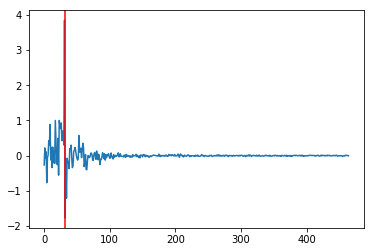

In [91]:
from numpy.fft import rfft

fourier_t = rfft(z_mean)

fig, ax = plt.subplots()
ax.plot(range(fourier_t.shape[0]-1),fourier_t[1:])
ax.axvline(32, color='r')
plt.show()

466


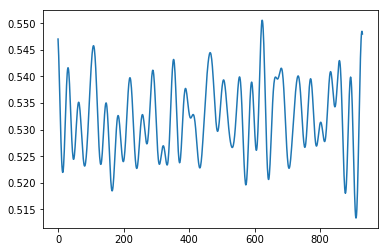

In [90]:
from numpy.fft import irfft
print(fourier_t.shape[0])

s = irfft(fourier_t[0:32],n=z_mean.shape[0])

fig, ax = plt.subplots()
ax.plot(range(s.shape[0]),s)
plt.show()